### Introduction to Hierarchical Bayes

In this lecture we'll cover a basic intro to hierarchical Bayesian modelling (HBM)/hierarchical probabilistic inference. We'll cover the following:

1) What is HBM?
 - Where is it used/why is it useful?
 - Some examples
 
2) Worked example: fitting a line to data.
 - With emcee.
 - With PyMC3.
 
3) Exercise:
 - Gaia distances

# 1. What is HBM?

"Hierarchical Bayesian modelling is where you learn about an underlying population (or individual) using a group of individuals (or observations)". -- Angie Wolfgang.

Some types of hierarchical Bayesian models could also be described as a type of Bayesian inference where you infer the parameters of the model AND the parameters of the prior at the same time.

**The simplest HBM.**

Most data analysis problems in astronomy can be written as a hierarchical problem, but often aren't. For example,  any time there is any 'data reduction' step, that step could be included hierarchically in the inference. However, it isn't always necessary to build a hierarchical model -- sometime it could add a lot of computation time to an otherwise trivial calculation. 

**Where is it used?**

*Examples.*

 - H_0.
 - Stellar populations (The CMD/HRD).
 - Stellar ages.
 - Combining measurements, e.g RVs from separate orders, rotation periods from separate light curves.
 - Exoplanet populations/stellar flares/rotation periods.
 

**Why is it useful?**

HBM is often the more principled way to perform parameter estimation in astronomy, but there are some real situations where HBM is really the only way to solve a problem.

However, there are also some examples of problems that do not necessarily need to be hierarchical. Be pragmatic.

Cons: usually involves LOTS of parameters...

*Exercise: Discuss with a partner how a project you've worked/are working on could be made hierarchical.*

# 2. Example: fitting a line to data

Let's start with fitting a line to data, "The 'hello world' of astrostats" -- Dan Foreman-Mackey.

In general, whenever I start a new problem that requires an HBM, I always draw a PGM to begin with, and write out the joint probability with its conditional factorization before writing code.

*Exercise: Draw the PGM for a non-hierarchical straight line model*

*Exersise: Write down the joint probability for this model and the factorization.*

*Question: How might this be a hierarchical problem?*

--Draw the hierarchical PGM and factorization--

Let's code this up. We'll start by simulating some data. First, let's draw values of a and b from the priors, using the hyperparameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# M is the number of lines.
M = 25

# Draw 'a' values from a Gaussian with mean, mu_a, and standard deviation, sigma_a.
# This will be our prior when we do the inference. mu_a and sigma_a will be the hyperparameters.
true_mu_a = 1.02
true_sigma_a = .4
true_a = np.random.randn(M)*true_sigma_a + true_mu_a

# Similarly, draw 'b' values from a Gaussian with mean, mu_b, and standard deviation, sigma_b.
true_mu_b = .52
true_sigma_b = .08
true_b = np.random.randn(M)*true_sigma_b + true_mu_b

Let's plot these distributions

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


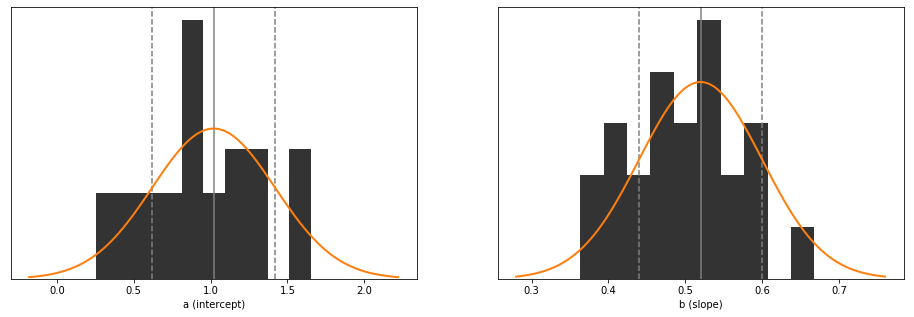

In [2]:
def Gaussian(x, mu, sigma):
    return 1./(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/sigma**2/2)

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax.hist(true_a, normed=True, color=".2");
ax.set_xlabel("a (intercept)")
ax.axvline(true_mu_a, color=".5")
ax.axvline(true_mu_a - true_sigma_a, color=".5", ls="--")
ax.axvline(true_mu_a + true_sigma_a, color=".5", ls="--")

xa = np.linspace(true_mu_a - (3*true_sigma_a), true_mu_a + (3*true_sigma_a), 100)
plt.plot(xa, Gaussian(xa, true_mu_a, true_sigma_a), color="C1", lw=2)

ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(122)
ax.hist(true_b, normed=True, color=".2");
ax.set_xlabel("b (slope)")
ax.axvline(true_mu_b, color=".5")
ax.axvline(true_mu_b - true_sigma_b, color=".5", ls="--")
ax.axvline(true_mu_b + true_sigma_b, color=".5", ls="--")

xb = np.linspace(true_mu_b - (3*true_sigma_b), true_mu_b + (3*true_sigma_b), 100)
plt.plot(xb, Gaussian(xb, true_mu_b, true_sigma_b), color="C1", lw=2)

ax.axes.get_yaxis().set_visible(False)

Now simulate the observations

In [3]:
# N is the number of x-y observations.
N = 10

# y is observed with noise.
sigma_y = 5
yerr = np.tile(np.ones(N)*sigma_y, (M, 1))

np.random.seed(42)

x = np.tile(np.linspace(0, 9, N), (M, 1))
y = true_a[:, None] + true_b[:, None]*x + np.random.randn(M, N)*sigma_y

Let's plot all the lines on the same axes.

Text(0, 0.5, 'y')

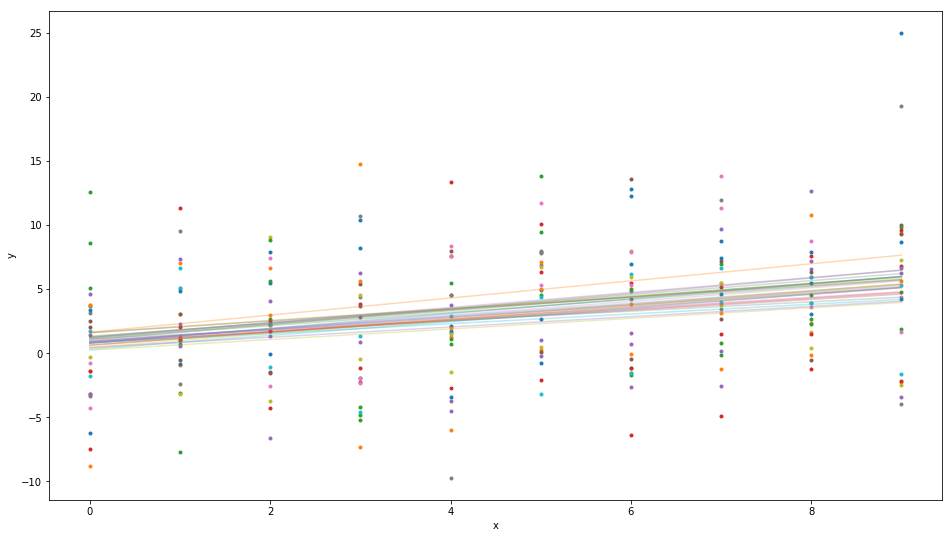

In [4]:
plt.figure(figsize=(16, 9))
plt.plot(x.T, y.T, ".")
plt.plot(true_a[None, :] + true_b[None, :]*x.T, alpha=.3)
plt.xlabel("x")
plt.ylabel("y")

Plot the first line.

Text(0, 0.5, 'y')

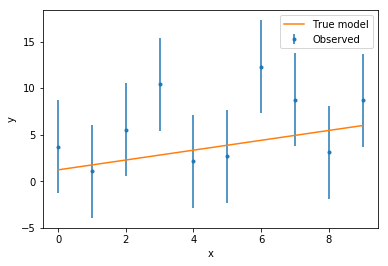

In [5]:
plt.errorbar(x[0, :], y[0, :], yerr=yerr[0, :], fmt=".", label="Observed")
plt.plot(x[0, :], true_a[0] + true_b[0]*x[0, :], label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Let's start by fitting a straight line to these data (although you don't really need to use MCMC to fit a straight line because there's an analytic solution).

The sampling method we choose will dictate how we write the code. We're going to start with PyMC3 but if we get time we'll look at how to code this up using emcee.

First we'll define the model.

In [10]:
import pymc3 as pm

simple_model = pm.Model()

with simple_model:
    
    # Priors over a and b
    a = pm.Uniform("a", lower=-10, upper=10)
    b = pm.Uniform("b", lower=-10, upper=10)

    # The deterministic model
    mu = pm.Deterministic("mu", a + b*x[0, :])

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=yerr[0, :], observed=y[0, :])

There's a nice tool that draws the PGM from the model.

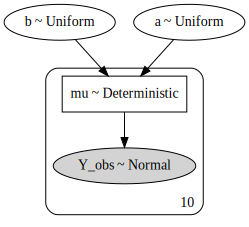

In [11]:
pm.model_to_graphviz(simple_model)

Sample

In [12]:
with simple_model:
    trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:10<00:00, 3982.05draws/s]
The acceptance probability does not match the target. It is 0.8932729690856205, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Make the diagnostic plots.

Posterior marginals:

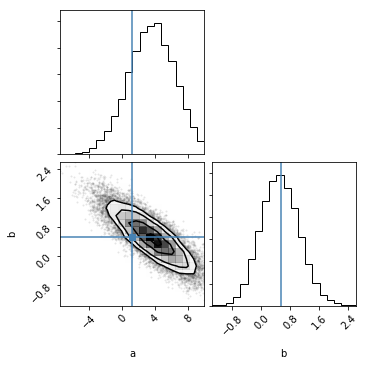

In [15]:
import corner

samples = np.vstack((trace.a, trace.b)).T
labels = ["a", "b"]
corner.corner(samples, truths=[true_a[0], true_b[0]], labels=labels);

Plot the chains:

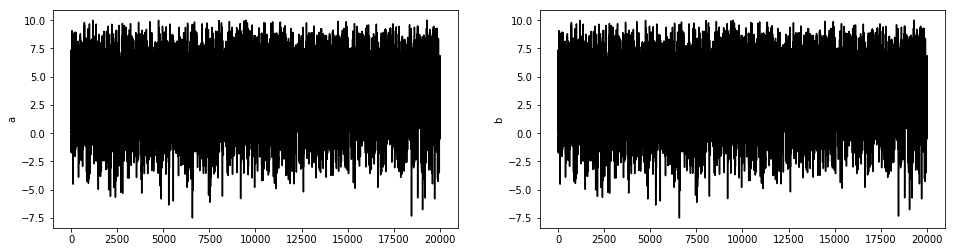

In [16]:
ndim = 2

fig = plt.figure(figsize=(16, 4))
for i in range(ndim):
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(samples[:, 0], "k")
    ax.set_ylabel(labels[i])

Let's calculate summary statistics:

In [17]:
inf_a, inf_b = np.median(samples, axis=0)
aerr, berr = np.std(samples[:, 0]), np.std(samples[:, 1])
print("True a = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_a[0], inf_a, aerr))
print("True b = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_b[0], inf_b, berr))

True a = 1.22, Inferred = 3.57 +/- 2.77
True b = 0.53, Inferred = 0.50 +/- 0.52


And plot the result on top of the true line.

Text(0, 0.5, 'y')

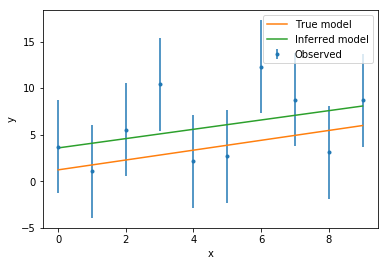

In [18]:
inf_a, inf_b = np.median(samples, axis=0)

plt.errorbar(x[0, :], y[0, :], yerr=yerr[0, :], fmt=".", label="Observed")
plt.plot(x[0, :], true_a[0] + true_b[0]*x[0, :], label="True model")
plt.plot(x[0, :], inf_a + inf_b*x[0, :], label="Inferred model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Those error bars are pretty large. Let's see if we can do better with a hierarchical version.

*Exercise: discuss with a partner how you the model will change in the hierarchical version*

*Question: How many free parameters will there be in the hierarchical model?*

In [19]:
# The model (deterministic)
def model(a, b, x):
    return a + b*x

hierarchical_model = pm.Model()

with hierarchical_model:
    
    # hyperpriors over mu_a, mu_b, sigma_a, and sigma_b
    mu_a = pm.Uniform("mu_a", lower=-10, upper=10)
    mu_b = pm.Uniform("mu_b", lower=-10, upper=10)
    ln_sigma_a = pm.Uniform("ln_sigma_a", lower=-3, upper=2)
    ln_sigma_b = pm.Uniform("ln_sigma_b", lower=-3, upper=2)
    
    # Priors over a and b -- now these are inferred.
    ahat = pm.Normal("ahat", mu=0, sigma=1, shape=M)
    a = pm.Deterministic("a", ahat*pm.math.exp(ln_sigma_a) + mu_a)
    bhat = pm.Normal("bhat", mu=0, sigma=1, shape=M)
    b = pm.Deterministic("b", bhat*pm.math.exp(ln_sigma_b) + mu_b)

    # The deterministic model
    mu = pm.Deterministic("mu", model(a[:, None], b[:, None], x))

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=yerr, observed=y)

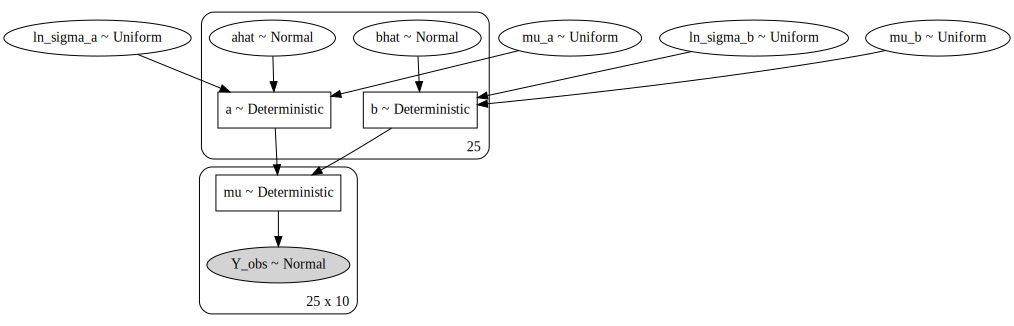

In [20]:
pm.model_to_graphviz(hierarchical_model)

In [21]:
with hierarchical_model:
    htrace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bhat, ahat, ln_sigma_b, ln_sigma_a, mu_b, mu_a]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.19draws/s]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5972894948785832, but should be close to 0.8. Try to increase the number of tuning steps.


Let's look at the results for the first line again.

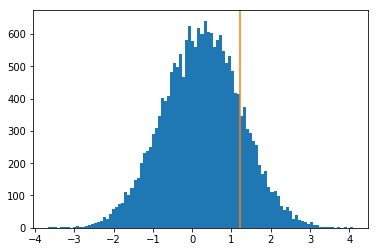

In [22]:
plt.hist(htrace.ahat[:, 0], 100);
plt.axvline(true_a[0], color="C1")

In [23]:
inf_a0, inf_b0 = np.median(htrace.ahat[:, 0], axis=0), np.median(htrace.bhat[:, 0], axis=0)
aerr0, berr0 = np.std(htrace.ahat[:, 0]), np.std(htrace.bhat[:, 0])
print("True a = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_a[0], inf_a0, aerr0))
print("True b = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_b[0], inf_b0, berr0))

True a = 1.22, Inferred = 0.26 +/- 0.99
True b = 0.53, Inferred = 0.51 +/- 0.88


Text(0, 0.5, 'y')

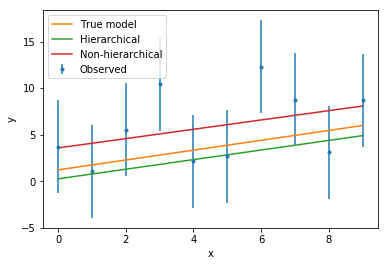

In [24]:
plt.errorbar(x[0, :], y[0, :], yerr=yerr[0, :], fmt=".", label="Observed")
plt.plot(x[0, :], true_a[0] + true_b[0]*x[0, :], label="True model")
plt.plot(x[0, :], inf_a0 + inf_b0*x[0, :], label="Hierarchical")
plt.plot(x[0, :], inf_a + inf_b*x[0, :], label="Non-hierarchical")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Let's plot the population parameters.

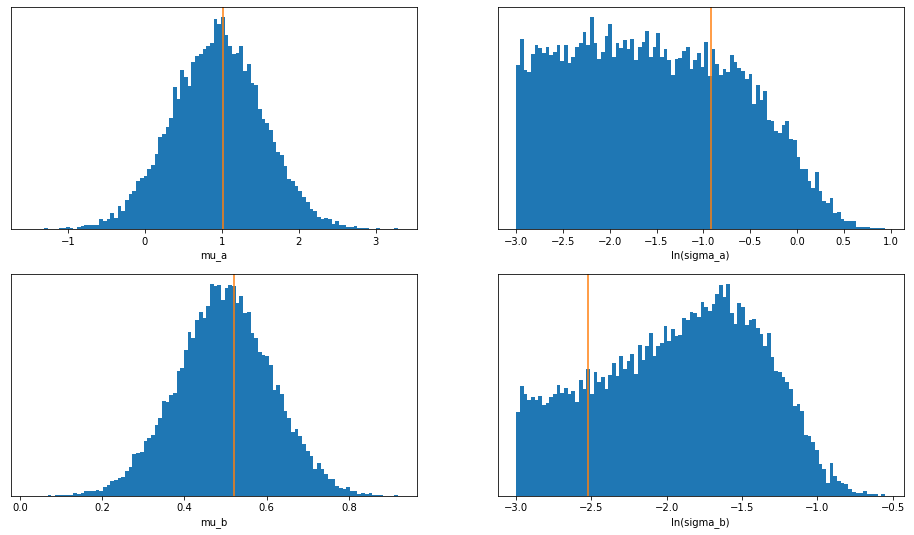

In [25]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(221)
ax.hist(htrace.mu_a, 100);
ax.axvline(true_mu_a, color="C1")
ax.set_xlabel("mu_a")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(222)
ax.hist(htrace.ln_sigma_a, 100);

ax.axvline(np.log(true_sigma_a), color="C1")
ax.set_xlabel("ln(sigma_a)")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(223)
ax.hist(htrace.mu_b, 100);
ax.axvline(true_mu_b, color="C1")
ax.set_xlabel("mu_b")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(224)
ax.hist(htrace.ln_sigma_b, 100);
ax.axvline(np.log(true_sigma_b), color="C1")
ax.set_xlabel("ln(sigma_b)")
ax.axes.get_yaxis().set_visible(False)

We just fit so many parameters!!!

This is a case where the population of lines helped inform the individual line.

*Exercise: try adjusting M and see how these results change.*
*Try adjusting the uncertainties on the data points and see how these results change.*

How would we code this up in emcee? We won't run this because there are a lot of parameters and emcee isn't designed for that. However, I think it's useful to think about how to code these models up using emcee.

*Discuss with a partner how the following functions would change in the hierarchical version*

In [27]:
# Code for fitting a single straight line in emcee

# The model (deterministic)
def model(a, b, x):
    return a + b*x

# The likelihood function
def lnlike(pars, x, y, yerr):
    a, b = pars
    ymodel = model(a, b, x)
    return -.5*np.sum((ymodel - y)**2/yerr**2)

# The prior function (stochastic/probabilistic)
def lnprior(pars):
    a, b = pars
    if -10 < a and a < 10 and -10 < b and b < 10:
        return 0.
    return -np.inf
    
# The posterior function
def lnprob(pars, x, y, yerr):
    return lnlike(pars, x, y, yerr) + lnprior(pars)